In [378]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import time
# preprocessing and pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from outlier_cleaner import OutlierCleaner



# sklearn libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,
    VotingRegressor, StackingRegressor, RandomForestClassifier, VotingClassifier
)

# sklearn metrics
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_score
from extended_sklearn_metrics import evaluate_model_with_cross_validation

# extra model
import xgboost as xgb

import joblib

In [379]:
df = pd.read_csv('heart_attack_prediction_indonesia.csv', nrows=50000)
df.columns

Index(['age', 'gender', 'region', 'income_level', 'hypertension', 'diabetes',
       'cholesterol_level', 'obesity', 'waist_circumference', 'family_history',
       'smoking_status', 'alcohol_consumption', 'physical_activity',
       'dietary_habits', 'air_pollution_exposure', 'stress_level',
       'sleep_hours', 'blood_pressure_systolic', 'blood_pressure_diastolic',
       'fasting_blood_sugar', 'cholesterol_hdl', 'cholesterol_ldl',
       'triglycerides', 'EKG_results', 'previous_heart_disease',
       'medication_usage', 'participated_in_free_screening', 'heart_attack'],
      dtype='object')

In [380]:
df['alcohol_consumption'] = df['alcohol_consumption'].fillna('None')

In [381]:
df.isna().any()

age                               False
gender                            False
region                            False
income_level                      False
hypertension                      False
diabetes                          False
cholesterol_level                 False
obesity                           False
waist_circumference               False
family_history                    False
smoking_status                    False
alcohol_consumption               False
physical_activity                 False
dietary_habits                    False
air_pollution_exposure            False
stress_level                      False
sleep_hours                       False
blood_pressure_systolic           False
blood_pressure_diastolic          False
fasting_blood_sugar               False
cholesterol_hdl                   False
cholesterol_ldl                   False
triglycerides                     False
EKG_results                       False
previous_heart_disease            False


In [382]:
df.duplicated().any()

False

In [383]:
df.dtypes

age                                 int64
gender                             object
region                             object
income_level                       object
hypertension                        int64
diabetes                            int64
cholesterol_level                   int64
obesity                             int64
waist_circumference                 int64
family_history                      int64
smoking_status                     object
alcohol_consumption                object
physical_activity                  object
dietary_habits                     object
air_pollution_exposure             object
stress_level                       object
sleep_hours                       float64
blood_pressure_systolic             int64
blood_pressure_diastolic            int64
fasting_blood_sugar                 int64
cholesterol_hdl                     int64
cholesterol_ldl                     int64
triglycerides                       int64
EKG_results                       

In [384]:
df['cholesterol ratio'] = df['cholesterol_hdl']/df['cholesterol_ldl']
df = df.drop(labels=['cholesterol_hdl', 'cholesterol_ldl'], axis=1)
df['obesity_risk_score'] = np.where(df['gender'] == 'Male' , df['obesity'] * 1 + (df['waist_circumference'] > 102) * 0.5, df['obesity'] * 1 + (df['waist_circumference'] > 88) * 0.5)
df = df.drop(labels=['obesity', 'waist_circumference'], axis=1)
df['pulse_pressure'] = df['blood_pressure_systolic'] - df['blood_pressure_diastolic']
df = df.drop(labels=['blood_pressure_systolic', 'blood_pressure_diastolic'], axis=1)
stress_mapping = {
    'Low': 1,        
    'Moderate': 2,   
    'High': 3        
}
df['stress_level'] = df['stress_level'].map(stress_mapping)
df['stress_to_sleep_ratio'] = -(df['stress_level'] / df['sleep_hours'])
df = df.drop(labels=['stress_level', 'sleep_hours'], axis=1)
df

,age,gender,region,income_level,hypertension,diabetes,cholesterol_level,family_history,smoking_status,alcohol_consumption,...,triglycerides,EKG_results,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
0,60,Male,Rural,Middle,0,1,211,0,Never,None,...,101,Normal,0,0,0,0,0.396694,0.0,51,-0.334975
1,53,Female,Urban,Low,0,0,208,1,Past,None,...,138,Normal,1,0,1,0,0.698795,0.5,56,-0.531556
2,62,Female,Urban,Low,0,0,231,1,Past,Moderate,...,171,Abnormal,0,1,0,1,0.530769,1.5,42,-0.157823
3,73,Male,Urban,Low,1,0,202,1,Never,Moderate,...,146,Normal,0,1,1,0,0.611765,0.0,71,-0.379123
4,52,Male,Urban,Middle,1,0,232,0,Current,Moderate,...,139,Normal,1,0,1,1,0.464567,0.0,52,-0.614942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,55,Female,Urban,Middle,0,0,226,1,Past,None,...,134,Normal,0,0,1,0,0.243590,0.5,63,-0.204422
49996,54,Male,Urban,Low,0,0,192,1,Never,None,...,145,Normal,0,1,0,0,0.358779,0.0,63,-0.446792
49997,61,Female,Rural,Middle,0,0,222,0,Never,Moderate,...,133,Normal,0,1,0,0,0.340741,0.5,77,-0.171914
49998,58,Male,Urban,High,0,0,227,0,Never,None,...,175,Normal,0,1,1,0,1.051724,0.0,42,-0.145684


In [385]:
cat_df = df.select_dtypes(include='object')
cat_df

,gender,region,income_level,smoking_status,alcohol_consumption,physical_activity,dietary_habits,air_pollution_exposure,EKG_results
0,Male,Rural,Middle,Never,None,High,Unhealthy,Moderate,Normal
1,Female,Urban,Low,Past,None,Moderate,Healthy,High,Normal
2,Female,Urban,Low,Past,Moderate,Moderate,Healthy,Low,Abnormal
3,Male,Urban,Low,Never,Moderate,Moderate,Unhealthy,Low,Normal
4,Male,Urban,Middle,Current,Moderate,Moderate,Unhealthy,High,Normal
...,...,...,...,...,...,...,...,...,...
49995,Female,Urban,Middle,Past,None,Moderate,Unhealthy,Moderate,Normal
49996,Male,Urban,Low,Never,None,Low,Unhealthy,Moderate,Normal
49997,Female,Rural,Middle,Never,Moderate,High,Unhealthy,High,Normal
49998,Male,Urban,High,Never,None,Moderate,Healthy,High,Normal


In [386]:
num_df = df.select_dtypes(exclude='object')
num_df

,age,hypertension,diabetes,cholesterol_level,family_history,fasting_blood_sugar,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
0,60,0,1,211,0,173,101,0,0,0,0,0.396694,0.0,51,-0.334975
1,53,0,0,208,1,70,138,1,0,1,0,0.698795,0.5,56,-0.531556
2,62,0,0,231,1,118,171,0,1,0,1,0.530769,1.5,42,-0.157823
3,73,1,0,202,1,98,146,0,1,1,0,0.611765,0.0,71,-0.379123
4,52,1,0,232,0,104,139,1,0,1,1,0.464567,0.0,52,-0.614942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,55,0,0,226,1,70,134,0,0,1,0,0.243590,0.5,63,-0.204422
49996,54,0,0,192,1,100,145,0,1,0,0,0.358779,0.0,63,-0.446792
49997,61,0,0,222,0,121,133,0,1,0,0,0.340741,0.5,77,-0.171914
49998,58,0,0,227,0,86,175,0,1,1,0,1.051724,0.0,42,-0.145684


In [387]:
encoder = LabelEncoder()
for cols in cat_df:
    cat_df[cols+'_encoded'] = encoder.fit_transform(cat_df[cols])
cat_df = cat_df.select_dtypes(exclude='object')
# len(cat_df.columns)
cat_df

,gender_encoded,region_encoded,income_level_encoded,smoking_status_encoded,alcohol_consumption_encoded,physical_activity_encoded,dietary_habits_encoded,air_pollution_exposure_encoded,EKG_results_encoded
0,1,0,2,1,2,0,1,2,1
1,0,1,1,2,2,2,0,0,1
2,0,1,1,2,1,2,0,1,0
3,1,1,1,1,1,2,1,1,1
4,1,1,2,0,1,2,1,0,1
...,...,...,...,...,...,...,...,...,...
49995,0,1,2,2,2,2,1,2,1
49996,1,1,1,1,2,1,1,2,1
49997,0,0,2,1,1,0,1,0,1
49998,1,1,0,1,2,2,0,0,1


In [388]:
df = pd.concat([cat_df, num_df], axis=1)

In [389]:
df

,gender_encoded,region_encoded,income_level_encoded,smoking_status_encoded,alcohol_consumption_encoded,physical_activity_encoded,dietary_habits_encoded,air_pollution_exposure_encoded,EKG_results_encoded,age,...,fasting_blood_sugar,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
0,1,0,2,1,2,0,1,2,1,60,...,173,101,0,0,0,0,0.396694,0.0,51,-0.334975
1,0,1,1,2,2,2,0,0,1,53,...,70,138,1,0,1,0,0.698795,0.5,56,-0.531556
2,0,1,1,2,1,2,0,1,0,62,...,118,171,0,1,0,1,0.530769,1.5,42,-0.157823
3,1,1,1,1,1,2,1,1,1,73,...,98,146,0,1,1,0,0.611765,0.0,71,-0.379123
4,1,1,2,0,1,2,1,0,1,52,...,104,139,1,0,1,1,0.464567,0.0,52,-0.614942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,2,2,2,2,1,2,1,55,...,70,134,0,0,1,0,0.243590,0.5,63,-0.204422
49996,1,1,1,1,2,1,1,2,1,54,...,100,145,0,1,0,0,0.358779,0.0,63,-0.446792
49997,0,0,2,1,1,0,1,0,1,61,...,121,133,0,1,0,0,0.340741,0.5,77,-0.171914
49998,1,1,0,1,2,2,0,0,1,58,...,86,175,0,1,1,0,1.051724,0.0,42,-0.145684


In [390]:
# encoder_hot = OneHotEncoder(sparse_output=False)
# encoded_data = encoder_hot.fit_transform(cat_df)
# encoded_feature_names = encoder_hot.get_feature_names_out(cat_df.columns)
# cat_df = pd.DataFrame(encoded_data, columns = encoded_feature_names)
# df = pd.concat([num_df, cat_df], axis=1)
# df

In [391]:
df.dtypes

gender_encoded                      int32
region_encoded                      int32
income_level_encoded                int32
smoking_status_encoded              int32
alcohol_consumption_encoded         int32
physical_activity_encoded           int32
dietary_habits_encoded              int32
air_pollution_exposure_encoded      int32
EKG_results_encoded                 int32
age                                 int64
hypertension                        int64
diabetes                            int64
cholesterol_level                   int64
family_history                      int64
fasting_blood_sugar                 int64
triglycerides                       int64
previous_heart_disease              int64
medication_usage                    int64
participated_in_free_screening      int64
heart_attack                        int64
cholesterol ratio                 float64
obesity_risk_score                float64
pulse_pressure                      int64
stress_to_sleep_ratio             

In [392]:
len(df.columns.tolist())

24

In [393]:
df.isna().any()

gender_encoded                    False
region_encoded                    False
income_level_encoded              False
smoking_status_encoded            False
alcohol_consumption_encoded       False
physical_activity_encoded         False
dietary_habits_encoded            False
air_pollution_exposure_encoded    False
EKG_results_encoded               False
age                               False
hypertension                      False
diabetes                          False
cholesterol_level                 False
family_history                    False
fasting_blood_sugar               False
triglycerides                     False
previous_heart_disease            False
medication_usage                  False
participated_in_free_screening    False
heart_attack                      False
cholesterol ratio                 False
obesity_risk_score                False
pulse_pressure                    False
stress_to_sleep_ratio             False
dtype: bool

In [394]:
df.duplicated().any()

False

In [395]:
cleaner = OutlierCleaner(df, preserve_index=True)
for column in df:
    analysis = cleaner.analyze_distribution(column)
    print(f"\n{column} Analysis:")
    print(f"- Skewness: {analysis['skewness']:.2f}")
    print(f"- Recommended method: {analysis['recommended_method']}")


gender_encoded Analysis:
- Skewness: -0.08
- Recommended method: modified_zscore

region_encoded Analysis:
- Skewness: -0.63
- Recommended method: modified_zscore

income_level_encoded Analysis:
- Skewness: -0.51
- Recommended method: modified_zscore

smoking_status_encoded Analysis:
- Skewness: 0.01
- Recommended method: modified_zscore

alcohol_consumption_encoded Analysis:
- Skewness: -0.99
- Recommended method: modified_zscore

physical_activity_encoded Analysis:
- Skewness: -0.34
- Recommended method: modified_zscore

dietary_habits_encoded Analysis:
- Skewness: -0.40
- Recommended method: modified_zscore

air_pollution_exposure_encoded Analysis:
- Skewness: -0.57
- Recommended method: modified_zscore

EKG_results_encoded Analysis:
- Skewness: -1.50
- Recommended method: modified_zscore

age Analysis:
- Skewness: 0.03
- Recommended method: modified_zscore

hypertension Analysis:
- Skewness: 0.89
- Recommended method: modified_zscore

diabetes Analysis:
- Skewness: 1.51
- Recommen

In [396]:
cleaned_df, info = cleaner.clean_columns(
    method='zscore',
    show_progress=True
)
cleaned_df

Cleaning columns: 100%|██████████| 24/24 [00:00<00:00, 289.71it/s]


,gender_encoded,region_encoded,income_level_encoded,smoking_status_encoded,alcohol_consumption_encoded,physical_activity_encoded,dietary_habits_encoded,air_pollution_exposure_encoded,EKG_results_encoded,age,...,fasting_blood_sugar,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
0,1,0,2,1,2,0,1,2,1,60,...,173,101,0,0,0,0,0.396694,0.0,51,-0.334975
1,0,1,1,2,2,2,0,0,1,53,...,70,138,1,0,1,0,0.698795,0.5,56,-0.531556
2,0,1,1,2,1,2,0,1,0,62,...,118,171,0,1,0,1,0.530769,1.5,42,-0.157823
3,1,1,1,1,1,2,1,1,1,73,...,98,146,0,1,1,0,0.611765,0.0,71,-0.379123
4,1,1,2,0,1,2,1,0,1,52,...,104,139,1,0,1,1,0.464567,0.0,52,-0.614942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,2,2,2,2,1,2,1,55,...,70,134,0,0,1,0,0.243590,0.5,63,-0.204422
49996,1,1,1,1,2,1,1,2,1,54,...,100,145,0,1,0,0,0.358779,0.0,63,-0.446792
49997,0,0,2,1,1,0,1,0,1,61,...,121,133,0,1,0,0,0.340741,0.5,77,-0.171914
49998,1,1,0,1,2,2,0,0,1,58,...,86,175,0,1,1,0,1.051724,0.0,42,-0.145684


In [397]:
df = cleaned_df

In [398]:
df.corr().sort_values(by='heart_attack')

,gender_encoded,region_encoded,income_level_encoded,smoking_status_encoded,alcohol_consumption_encoded,physical_activity_encoded,dietary_habits_encoded,air_pollution_exposure_encoded,EKG_results_encoded,age,...,fasting_blood_sugar,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,heart_attack,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
smoking_status_encoded,0.008548,0.000799,0.000942,1.000000,0.000565,-0.007809,-0.001263,0.001707,-0.005920,0.004099,...,-0.002499,-0.000620,0.000028,-0.000197,-0.003565,-0.133577,0.005574,-0.001421,0.000566,-0.001702
gender_encoded,1.000000,0.000122,0.000179,0.008548,0.001954,0.000754,-0.001498,-0.001670,0.004171,0.004976,...,0.008133,0.005316,-0.010924,-0.000905,0.005748,-0.010294,-0.000181,-0.147820,0.000729,-0.002263
physical_activity_encoded,0.000754,0.000482,0.000748,-0.007809,-0.002224,1.000000,0.000250,-0.003412,0.004040,0.002080,...,0.002053,-0.005808,-0.002465,-0.000028,0.004883,-0.008589,0.003616,-0.003686,0.003306,0.009477
alcohol_consumption_encoded,0.001954,0.001396,-0.001814,0.000565,1.000000,-0.002224,0.003600,0.012595,-0.003082,0.009710,...,-0.001383,-0.004846,-0.002029,-0.000822,-0.000555,-0.008244,0.000564,-0.000638,-0.001709,-0.006632
region_encoded,0.000122,1.000000,0.003449,0.000799,0.001396,0.000482,0.001693,-0.000575,0.006010,0.002565,...,-0.006702,0.007973,0.002242,-0.000649,0.002478,-0.007641,-0.000673,-0.000323,-0.007806,-0.006337
participated_in_free_screening,0.005748,0.002478,0.008007,-0.003565,-0.000555,0.004883,-0.002624,-0.001931,0.001174,0.005359,...,-0.004730,-0.001844,0.008851,-0.004710,1.000000,-0.007590,0.002682,-0.005129,0.000910,-0.003473
triglycerides,0.005316,0.007973,0.003807,-0.000620,-0.004846,-0.005808,-0.000216,0.003514,0.004010,-0.000171,...,0.008810,1.000000,0.007926,0.004469,-0.001844,-0.004392,0.007243,0.000063,-0.001425,-0.002178
air_pollution_exposure_encoded,-0.001670,-0.000575,0.002820,0.001707,0.012595,-0.003412,0.003926,1.000000,-0.002755,0.000033,...,-0.005712,0.003514,0.004143,-0.006253,-0.001931,-0.003871,0.002633,-0.003257,0.000622,0.005323
pulse_pressure,0.000729,-0.007806,-0.002382,0.000566,-0.001709,0.003306,-0.006009,0.000622,0.004523,-0.008139,...,0.002087,-0.001425,0.004408,-0.004951,0.000910,-0.002902,-0.003101,-0.001382,1.000000,0.000781
income_level_encoded,0.000179,0.003449,1.000000,0.000942,-0.001814,0.000748,0.002512,0.002820,0.000667,-0.000424,...,-0.001949,0.003807,-0.006075,0.001308,0.008007,-0.000403,0.005868,-0.003053,-0.002382,0.001791


<Axes: xlabel='heart_attack'>

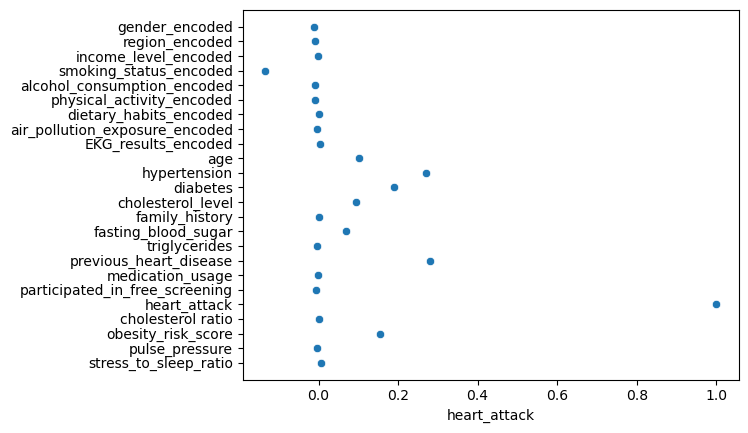

In [399]:
sns.scatterplot(data=df.corr(), x='heart_attack', y=df.columns.tolist())

In [400]:
x = df.drop('heart_attack', axis=1)
y = df['heart_attack']



In [401]:
x

,gender_encoded,region_encoded,income_level_encoded,smoking_status_encoded,alcohol_consumption_encoded,physical_activity_encoded,dietary_habits_encoded,air_pollution_exposure_encoded,EKG_results_encoded,age,...,family_history,fasting_blood_sugar,triglycerides,previous_heart_disease,medication_usage,participated_in_free_screening,cholesterol ratio,obesity_risk_score,pulse_pressure,stress_to_sleep_ratio
0,1,0,2,1,2,0,1,2,1,60,...,0,173,101,0,0,0,0.396694,0.0,51,-0.334975
1,0,1,1,2,2,2,0,0,1,53,...,1,70,138,1,0,1,0.698795,0.5,56,-0.531556
2,0,1,1,2,1,2,0,1,0,62,...,1,118,171,0,1,0,0.530769,1.5,42,-0.157823
3,1,1,1,1,1,2,1,1,1,73,...,1,98,146,0,1,1,0.611765,0.0,71,-0.379123
4,1,1,2,0,1,2,1,0,1,52,...,0,104,139,1,0,1,0.464567,0.0,52,-0.614942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,2,2,2,2,1,2,1,55,...,1,70,134,0,0,1,0.243590,0.5,63,-0.204422
49996,1,1,1,1,2,1,1,2,1,54,...,1,100,145,0,1,0,0.358779,0.0,63,-0.446792
49997,0,0,2,1,1,0,1,0,1,61,...,0,121,133,0,1,0,0.340741,0.5,77,-0.171914
49998,1,1,0,1,2,2,0,0,1,58,...,0,86,175,0,1,1,1.051724,0.0,42,-0.145684


In [402]:
y

0        0
1        0
2        1
3        0
4        1
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: heart_attack, Length: 48872, dtype: int64

In [403]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=23)

In [404]:
X_train.shape, X_test.shape

((34210, 23), (14662, 23))

In [405]:
# scaler = StandardScaler()

In [406]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)
# X_train_scaled, X_train_scaled[0]

In [407]:
SEED = 42

In [408]:
# dt = DecisionTreeClassifier()
# rf = RandomForestClassifier(random_state=SEED)
# svc = SVC()

In [409]:
# voting_classifier = VotingClassifier(
#     estimators=[('rf',rf),('dt',dt),('svc',svc)],
# )

In [410]:
# pipeline = Pipeline([
#     ('scaler',StandardScaler()),
#     ('classifier',voting_classifier),
# ])

In [411]:
# pipeline.fit(X_train, y_train)

In [412]:
# y_prediction = pipeline.predict(X_test)

In [413]:
# cm = confusion_matrix(y_test,y_prediction)
# sns.heatmap(cm, annot=True )
# plt.show()

In [414]:
# print(classification_report(y_test, y_prediction))

In [415]:
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'SVM': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier()
}

In [416]:
results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)
    ])
    pipeline.fit(X_train,y_train)
    y_prediction = pipeline.predict(X_test)
    results.append({
        'model': name,
        'classfication_report': classification_report(y_test, y_prediction)
    })
results

[{'model': 'DecisionTreeClassifier',
  'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.71      0.70      0.71      8801\n           1       0.56      0.57      0.57      5861\n\n    accuracy                           0.65     14662\n   macro avg       0.64      0.64      0.64     14662\nweighted avg       0.65      0.65      0.65     14662\n'},
 {'model': 'SVM',
  'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.61      0.98      0.75      8801\n           1       0.64      0.07      0.12      5861\n\n    accuracy                           0.61     14662\n   macro avg       0.62      0.52      0.43     14662\nweighted avg       0.62      0.61      0.50     14662\n'},
 {'model': 'RandomForestClassifier',
  'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.75      0.82      0.78      8801\n           1       0.69      0.59      

In [417]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regression': DecisionTreeRegressor(),
    'KNN Regression': KNeighborsRegressor(),
    'Random Forest Regression': RandomForestRegressor(), 
    'AdaBoost Regression': AdaBoostRegressor(),
}

In [418]:
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    results.append({
        'model':name,
        'R2_score':r2_score(y_test,y_pred),
        'RMSE':[mean_squared_error(y_test,y_pred)]
    })
    
results

[{'model': 'Linear Regression',
  'R2_score': 0.2480196163607642,
  'RMSE': [0.18043626290372092]},
 {'model': 'Ridge Regression',
  'R2_score': 0.24802232125551105,
  'RMSE': [0.18043561386937068]},
 {'model': 'Lasso Regression',
  'R2_score': 0.0057932516419356705,
  'RMSE': [0.23855801844088045]},
 {'model': 'Support Vector Regression',
  'R2_score': -0.06265779866231647,
  'RMSE': [0.25498271777806336]},
 {'model': 'Decision Tree Regression',
  'R2_score': -0.4593025357881402,
  'RMSE': [0.35015686809439367]},
 {'model': 'KNN Regression',
  'R2_score': -0.14222400740434882,
  'RMSE': [0.2740744782430774]},
 {'model': 'Random Forest Regression',
  'R2_score': 0.2476835238918751,
  'RMSE': [0.1805169076524349]},
 {'model': 'AdaBoost Regression',
  'R2_score': 0.19739607501117695,
  'RMSE': [0.19258328537239972]}]